In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calendar_data = pd.read_csv('Data/calendar.csv')
sales_data = pd.read_csv('Data/sales_train_validation.csv')
weekly_sale_price_data = pd.read_csv('Data/sell_prices.csv')

In [3]:
calendar_data['date'] = pd.DatetimeIndex(calendar_data.date)

In [4]:
sales_data_long = pd.melt(sales_data, 
                          id_vars = sales_data.columns[:6], value_vars = sales_data.columns[6:], 
                          var_name = 'd', value_name = 'sales')

In [5]:
print(sales_data_long.shape)
sales_data_long.head()

(58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [6]:
complete_data = sales_data_long.join(calendar_data.set_index('d'), 
                                     on = ['d'], how='left')
complete_data = complete_data.join(weekly_sale_price_data.set_index(['store_id', 'item_id', 'wm_yr_wk']), 
                                   on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

In [7]:
print(complete_data.shape)
print(complete_data.columns)
complete_data.head()

(58327370, 22)
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [8]:
complete_data['d'] = complete_data.d.apply(lambda x: x.split('_')[1]).astype(int)
complete_data['event_name_1'].fillna('', inplace = True)
complete_data['event_type_1'].fillna('', inplace = True)
complete_data['event_day'] = complete_data['event_name_1'].apply(lambda x: 0 if x == '' else 1)

#### Store Closed Days
Based on the results below, Christmas is the only day any of the stores are ever close, but even then that is not consistent for each year. It may be due to management or some unknown factor, but we for the sake if this work, we can't use a store closed field unless we make the data ourselves.

In [9]:
cumulative_store_sales = complete_data.groupby(['store_id', 'd', 'event_name_1']).sales.sum().reset_index()

In [10]:
cumulative_store_sales[cumulative_store_sales.sales == 0]

,store_id,d,event_name_1,sales
330,CA_1,331,Christmas,0
696,CA_1,697,Christmas,0
1061,CA_1,1062,Christmas,0
1426,CA_1,1427,Christmas,0
1791,CA_1,1792,Christmas,0
5252,CA_3,1427,Christmas,0
6069,CA_4,331,Christmas,0
6435,CA_4,697,Christmas,0
6800,CA_4,1062,Christmas,0
7165,CA_4,1427,Christmas,0


In [11]:
cumulative_store_sales.d.max()

1913

#### Determining discounts vs long term price changes

In [12]:
weekly_sale_price_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [13]:
weekly_sale_price_data['next_week_sale_price'] = weekly_sale_price_data \
                                                    .sort_values('wm_yr_wk') \
                                                    .groupby(['store_id', 'item_id']) \
                                                    .sell_price.shift(-1, fill_value = 0)
    
weekly_sale_price_data['sell_price_change'] = weekly_sale_price_data[['sell_price', 'next_week_sale_price']] \
                                                    .apply(lambda x: 0 if x[1] == 0 
                                                                       else ((x[1] / x[0]) - 1) * 100, 
                                                           axis = 1)

In [14]:
weekly_sale_price_data.head()

,store_id,item_id,wm_yr_wk,sell_price,next_week_sale_price,sell_price_change
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,0.000000
1,CA_1,HOBBIES_1_001,11326,9.58,8.26,-13.778706
2,CA_1,HOBBIES_1_001,11327,8.26,8.26,0.000000
3,CA_1,HOBBIES_1_001,11328,8.26,8.26,0.000000
4,CA_1,HOBBIES_1_001,11329,8.26,8.26,0.000000


In [15]:
weekly_price_changes = weekly_sale_price_data[weekly_sale_price_data['sell_price_change'] != 0]

In [16]:
weekly_price_changes.shape

(78815, 6)

In [17]:
weekly_price_changes.head(20)

,store_id,item_id,wm_yr_wk,sell_price,next_week_sale_price,sell_price_change
1,CA_1,HOBBIES_1_001,11326,9.58,8.26,-13.778706
142,CA_1,HOBBIES_1_001,11610,8.26,8.38,1.452785
643,CA_1,HOBBIES_1_004,11304,4.34,4.64,6.912442
835,CA_1,HOBBIES_1_005,11134,2.98,2.48,-16.778523
853,CA_1,HOBBIES_1_005,11152,2.48,2.98,20.161290
895,CA_1,HOBBIES_1_005,11242,2.98,3.08,3.355705
982,CA_1,HOBBIES_1_005,11424,3.08,2.88,-6.493506
1249,CA_1,HOBBIES_1_006,11518,1.00,0.96,-4.000000
1322,CA_1,HOBBIES_1_007,11241,7.94,7.88,-0.755668
1514,CA_1,HOBBIES_1_008,11103,0.46,0.42,-8.695652


In [18]:
weekly_price_changes[['store_id', 'item_id']].drop_duplicates().shape

(22243, 2)

In [19]:
count_price_changes = weekly_price_changes.groupby(['store_id', 'item_id']).sell_price_change.count().reset_index()
multiple_price_changes = count_price_changes[count_price_changes['sell_price_change'] > 1][['store_id', 'item_id']]

In [20]:
multiple_price_changes.shape

(15896, 2)

In [21]:
potential_discounts = pd.merge(left = weekly_price_changes, right = multiple_price_changes, 
                               left_on = ['store_id', 'item_id'], right_on = ['store_id', 'item_id'])

In [22]:
potential_discounts['discount_end_week'] = potential_discounts \
                                                .sort_values('wm_yr_wk') \
                                                .groupby(['store_id', 'item_id']) \
                                                .wm_yr_wk.shift(-1, fill_value = 0)
potential_discounts['after_discount_price'] = potential_discounts \
                                                .sort_values('wm_yr_wk') \
                                                .groupby(['store_id', 'item_id']) \
                                                .next_week_sale_price.shift(-1, fill_value = 0)

In [23]:
potential_discounts.head()

,store_id,item_id,wm_yr_wk,sell_price,next_week_sale_price,sell_price_change,discount_end_week,after_discount_price
0,CA_1,HOBBIES_1_001,11326,9.58,8.26,-13.778706,11610,8.38
1,CA_1,HOBBIES_1_001,11610,8.26,8.38,1.452785,0,0.00
2,CA_1,HOBBIES_1_005,11134,2.98,2.48,-16.778523,11152,2.98
3,CA_1,HOBBIES_1_005,11152,2.48,2.98,20.161290,11242,3.08
4,CA_1,HOBBIES_1_005,11242,2.98,3.08,3.355705,11424,2.88


In [24]:
def week_difference(week_prior, week_end):
    start_year = int(week_prior[1:3])
    start_week = int(week_prior[3:])
    end_year = int(week_end[1:3])
    end_week = int(week_end[3:])
    if start_year == end_year:
        return(end_week - start_week + 1)
    else:
        year_diff_weeks = (end_year - start_year - 1) * 52
        start_and_end_weeks = (52 - start_week) + end_week
        return(start_and_end_weeks + year_diff_weeks)
        
potential_discounts['discounts_weeks_count'] = potential_discounts[['wm_yr_wk', 'discount_end_week']] \
                                                    .apply(lambda x: 0 if x[1] == 0 
                                                                       else week_difference(str(x[0]), str(x[1])), 
                                                           axis = 1)
discounts_counts = potential_discounts[potential_discounts['discount_end_week'] != 0]

In [25]:
discounts_counts.head(20)

,store_id,item_id,wm_yr_wk,sell_price,next_week_sale_price,sell_price_change,discount_end_week,after_discount_price,discounts_weeks_count
0,CA_1,HOBBIES_1_001,11326,9.58,8.26,-13.778706,11610,8.38,140
2,CA_1,HOBBIES_1_005,11134,2.98,2.48,-16.778523,11152,2.98,19
3,CA_1,HOBBIES_1_005,11152,2.48,2.98,20.161290,11242,3.08,42
4,CA_1,HOBBIES_1_005,11242,2.98,3.08,3.355705,11424,2.88,86
6,CA_1,HOBBIES_1_008,11103,0.46,0.42,-8.695652,11111,0.50,9
7,CA_1,HOBBIES_1_008,11111,0.42,0.50,19.047619,11251,0.46,92
8,CA_1,HOBBIES_1_008,11251,0.50,0.46,-8.000000,11511,0.48,116
10,CA_1,HOBBIES_1_012,11106,5.98,6.27,4.849498,11150,6.52,45
12,CA_1,HOBBIES_1_015,11103,0.70,0.72,2.857143,11113,0.68,11
13,CA_1,HOBBIES_1_015,11113,0.72,0.68,-5.555556,11127,0.70,15


(array([35187.,  9584.,  4227.,  3110.,  1626.,  1297.,   800.,   382.,
          227.,   132.]),
 array([  0. ,  27.1,  54.2,  81.3, 108.4, 135.5, 162.6, 189.7, 216.8,
        243.9, 271. ]),
 <a list of 10 Patch objects>)

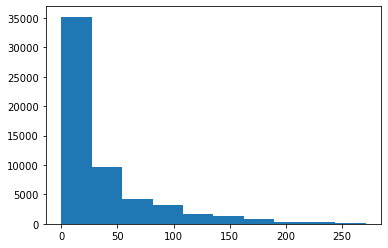

In [29]:
plt.hist(discounts_counts.discounts_weeks_count)

(array([13554.,  7045.,  5565.,  3936.,  3483.,  3621.,  1776.,  1792.,
         1530.,  1750.]),
 array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ]),
 <a list of 10 Patch objects>)

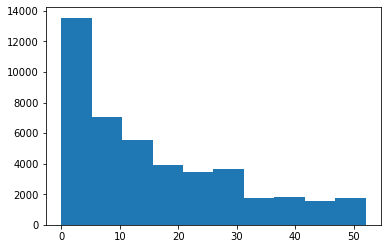

In [30]:
plt.hist(discounts_counts[discounts_counts['discounts_weeks_count'] <= 52 ].discounts_weeks_count)

#### Fun Plots

In [31]:
def quad_plot(dataset = complete_data, id_filter = 'id', series_id = 'FOODS_1_011_CA_1_validation', days_prior = 365):
    series_data = dataset[dataset[id_filter] == series_id]
    
    d_max = complete_data['d'].max()
    last_x_days = series_data[series_data['d'] >= (d_max-days_prior)]
    
    color_palette_set = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'black', 'pink']
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8), sharex = 'col')
    sns.lineplot(x = "date", y = "sales",
                 data = last_x_days, 
                 ax = axs[0, 0]).set_title('Last ' + str(days_prior) + ' Days Sales')
    sns.lineplot(x = "date", y = "event_day",  
                 data = last_x_days, 
                 ax = axs[1, 0]).set_title('Holidays')
    sns.lineplot(x = "date", y = "sell_price", hue = 'year', 
                 palette = color_palette_set[0:series_data.year.nunique()],
                 data = series_data, 
                 ax = axs[0, 1]).set_title('Weekly Price')
    sns.lineplot(x = "date", y = "sales", hue = 'year', 
                 palette = color_palette_set[0:series_data.year.nunique()],
                 data = series_data, 
                 ax = axs[1, 1]).set_title('Complete Sales')

    for ax in axs.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

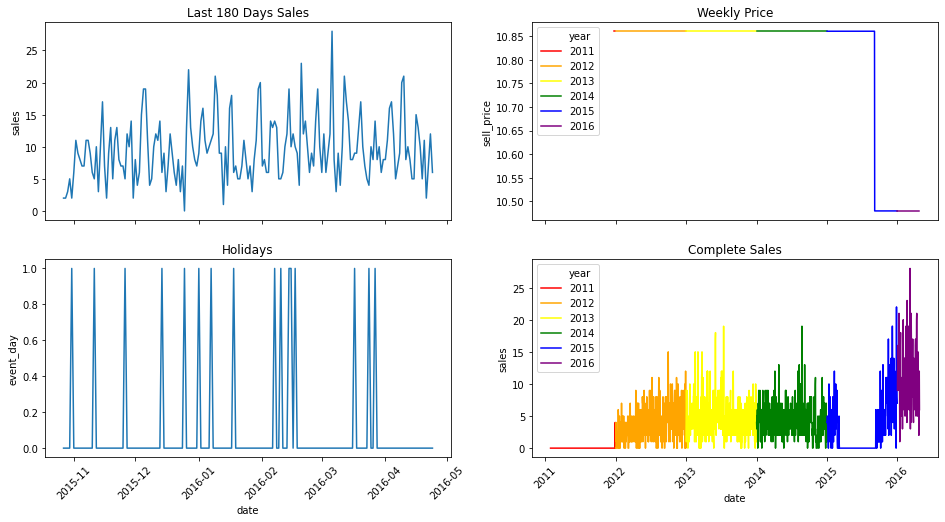

In [41]:
quad_plot(dataset = complete_data, id_filter = 'id', series_id = 'HOUSEHOLD_1_032_CA_1_validation', days_prior = 180)